# ACS Climate & Socioeconomic Analysis

This notebook explores socioeconomic characteristics of U.S. cities using the American Community Survey (ACS) 5-year estimates (2021), with a focus on factors that influence climate resilience.

**Key questions:**
- How does median household income vary across U.S. cities?
- Which cities have high renter populations (less housing stability)?
- How do commute patterns correlate with income and housing?
- Which cities may be structurally vulnerable to climate impacts?

**Future extension:** Overlay NOAA climate risk data (heat, flooding) to identify high-risk populations.

In [6]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width',120)

# plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,6)

In [10]:
## Data Source & API Configuration

data_source = "U.S. Census Bureau ACS 5-Year Estimates (2021)" 
geography = "Census Places (cities)"

In [12]:
API_KEY = os.getenv("be1583b7bba6d6bfd6a31b7e809ecdde2acbf1d7")

print("✓ API key loaded")

✓ API key loaded


## Data Acquisition

We're pulling city-level data for:
- Population
- Median household income
- Housing tenure (owner vs renter)
- Commute methods


In [19]:
BASE_URL = "https://api.census.gov/data/2021/acs/acs5"

variables = [
    "NAME",
    "B01001_001E",  # Total population
    "B19013_001E",  # Median household income
    "B25003_002E",  # Owner-occupied units
    "B25003_003E",  # Renter-occupied units
    "B08301_001E",  # Total commuters
    "B08301_010E",  # Public transit commuters
    "B08301_019E",  # Walk/bike commuters
]

params = {
    "get": ",".join(variables),
    "for": "place:*",
    "key": API_KEY,
}

response = requests.get(BASE_URL, params=params)
response.raise_for_status()

data = response.json()
print(f"✓ Pulled data for {len(data) - 1} places")

✓ Pulled data for 31908 places


In [20]:
columns = data[0]
rows = data[1:]

df = pd.DataFrame(rows, columns=columns)
df.head()

,NAME,B01001_001E,B19013_001E,B25003_002E,B25003_003E,B08301_001E,B08301_010E,B08301_019E,state,place
0,"Abanda CDP, Alabama",231,25787,67,0,92,0,0,01,00100
1,"Abbeville city, Alabama",2231,36944,591,331,706,15,7,01,00124
2,"Adamsville city, Alabama",4381,46150,1182,308,1546,0,19,01,00460
3,"Addison town, Alabama",697,44000,215,81,347,0,0,01,00484
4,"Akron town, Alabama",385,28438,79,13,172,0,0,01,00676


In [21]:
# Define which columns should be numeric

numeric_cols = [
    "B01001_001E",  # Total population
    "B19013_001E",  # Median household income
    "B25003_002E",  # Owner-occupied units
    "B25003_003E",  # Renter-occupied units
    "B08301_001E",  # Total commuters
    "B08301_010E",  # Public transit commuters
    "B08301_019E",  # Walk/bike commuters
]

# Convert to numeric
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Rename to meaningful names
df.rename(columns={
    "NAME": "Place",
    "B01001_001E": "Total_Population",
    "B19013_001E": "Median_Household_Income",
    "B25003_002E": "Owner_Occupied_Units",
    "B25003_003E": "Renter_Occupied_Units",
    "B08301_001E": "Total_Commuters",
    "B08301_010E": "Public_Transit_Commuters",
    "B08301_019E": "Walk_Bike_Commuters",
}, inplace=True)

# Drop rows with missing income data
df.dropna(subset=["Median_Household_Income"], inplace=True)

print("✓ Data cleaned and prepped for analysis")
df.head()

✓ Data cleaned and prepped for analysis


,Place,Total_Population,Median_Household_Income,Owner_Occupied_Units,Renter_Occupied_Units,Total_Commuters,Public_Transit_Commuters,Walk_Bike_Commuters,state,place
0,"Abanda CDP, Alabama",231,25787,67,0,92,0,0,01,00100
1,"Abbeville city, Alabama",2231,36944,591,331,706,15,7,01,00124
2,"Adamsville city, Alabama",4381,46150,1182,308,1546,0,19,01,00460
3,"Addison town, Alabama",697,44000,215,81,347,0,0,01,00484
4,"Akron town, Alabama",385,28438,79,13,172,0,0,01,00676


In [22]:
# Adding derived metrics for analytics

# Calculate percentage metrics
df["Renter_Occupancy_Rate"] = df["Renter_Occupied_Units"] / (df["Owner_Occupied_Units"] + df["Renter_Occupied_Units"])
df["Public_Transit_Usage_Rate"] = df["Public_Transit_Commuters"] / df["Total_Commuters"]
df["Walk_Bike_Usage_Rate"] = df["Walk_Bike_Commuters"] / df["Total_Commuters"]

# Filter to cities with meaningful population size
df = df[df["Total_Population"] >= 50000].copy()

print("✓ Derived metrics added and data filtered")
df.head()

✓ Derived metrics added and data filtered


,Place,Total_Population,Median_Household_Income,Owner_Occupied_Units,Renter_Occupied_Units,Total_Commuters,Public_Transit_Commuters,Walk_Bike_Commuters,state,place,Renter_Occupancy_Rate,Public_Transit_Usage_Rate,Walk_Bike_Usage_Rate
26,"Auburn city, Alabama",74637,54700,13997,13659,34562,456,1564,01,03076,0.493889,0.013194,0.045252
49,"Birmingham city, Alabama",202234,39403,39191,46330,87751,1601,2658,01,07000,0.541738,0.018245,0.030290
134,"Decatur city, Alabama",57303,52539,15363,8434,24842,58,284,01,20104,0.354414,0.002335,0.011432
141,"Dothan city, Alabama",70318,49203,16192,11559,29575,10,319,01,21184,0.416526,0.000338,0.010786
271,"Hoover city, Alabama",91371,95970,24512,10710,46321,73,162,01,35896,0.304071,0.001576,0.003497


## Exploratory Analysis

Now that we have clean data with derived metrics, let's explore patterns related to climate resilience:

**Income distribution** - Economic capacity across cities"
**Renter occupancy vs income** - Housing stability patterns"
**Transit dependency** - Infrastructure vulnerability"

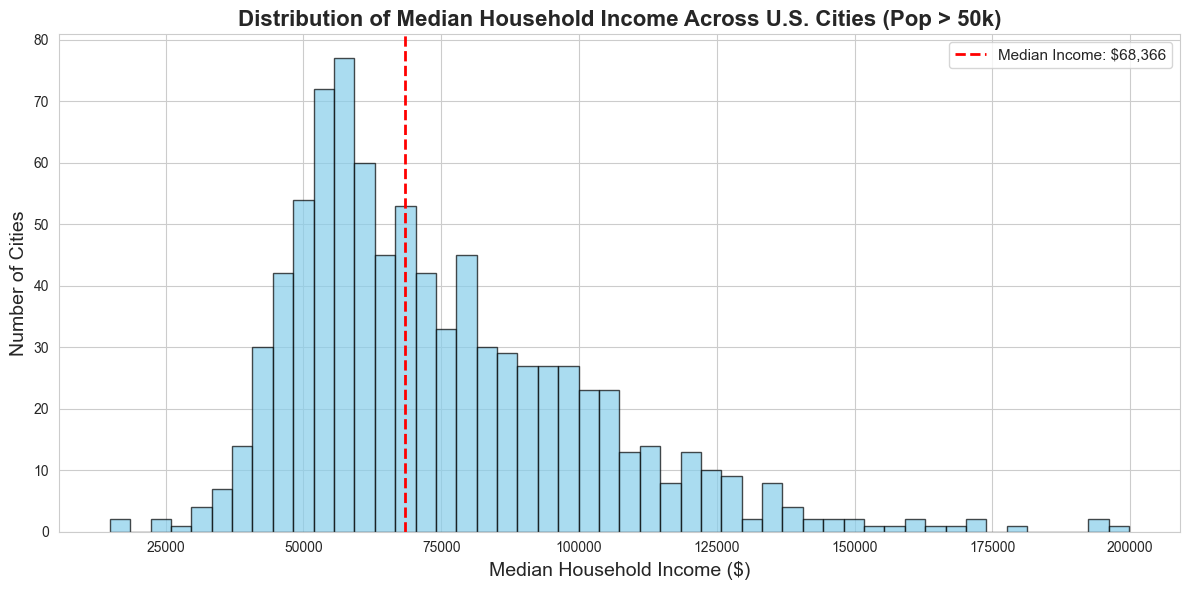

✓ Income distribution analyzed
Median Household Income across cities: $68,366
Mean Household Income across cities: $74,571
Range: $14,879 - $199,778


In [30]:
#Income Distribution
plt.figure(figsize=(12,6))
plt.hist(df["Median_Household_Income"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
median_income = df["Median_Household_Income"].median()
plt.axvline(median_income, color='red', linestyle='dashed', linewidth=2, label=f'Median Income: ${median_income:,.0f}')
plt.title("Distribution of Median Household Income Across U.S. Cities (Pop > 50k)", fontsize=16, fontweight='bold')
plt.xlabel("Median Household Income ($)", fontsize=14)
plt.ylabel("Number of Cities", fontsize=14)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"✓ Income distribution analyzed")
print(f"Median Household Income across cities: ${median_income:,.0f}")
print(f"Mean Household Income across cities: ${df['Median_Household_Income'].mean():,.0f}")
print(f"Range: ${df['Median_Household_Income'].min():,.0f} - ${df['Median_Household_Income'].max():,.0f}")


# Housing Tenure and Economic Vulnerability

Cities with high renter populations may face greater climate adaptation challenges:
Limited control over housing improvements (AC, insulation, weatherization)
Lower household wealth for emergency preparedness
Higher displacement risk during climate events